#### Libraries

In [111]:
########################## UTILITY AND SYSTEM ##########################

import os                       # filesystem operations
import csv                      # reading/writing CSV files
import json                     # JSON parsing and serialization
import math                     # basic math functions
import random                   # random number generation
import time                     # time-related functions
import tempfile                 # temporary file management
import tarfile                  # tar archive handling
import io                       # input/output streams
import pickle                   # object serialization
import importlib                # dynamic import of modules
import multiprocessing          # parallel process management
import pkg_resources            # package and dependency management
from copy import deepcopy       # deep copy of objects
from pathlib import Path        # filesystem paths handling (cross-platform)

########################## DOWNLOAD ##########################

import requests                 # HTTP requests library
import wget                     # file downloads from URLs
from urllib.request import urlopen  # open URLs (alternative to requests)

########################## VISUALIZATION ##########################

import matplotlib.pyplot as plt # basic plotting library
import plotly.graph_objs as go  # interactive plotting
from tqdm.notebook import tqdm  # progress bars for loops in notebooks
from pprint import pprint       # formatted pretty-printing of objects

########################## DATAFRAME ##########################

import numpy as np              # numerical arrays and operations
import pandas as pd             # dataframes and data manipulation
from sklearn.manifold import TSNE

########################## TEXT PROCESSING ##########################

import re                      # regular expressions
import string                  # string constants and operations
from itertools import chain, islice  # advanced iteration and chaining

########################## TOKENIZATION ##########################

from collections import Counter, OrderedDict  # frequency counts and ordered dictionaries
import nltk                                   # natural language processing toolkit
from nltk.tokenize import word_tokenize       # word tokenization
import spacy                                  # advanced NLP (tokenization, parsing)
from torchtext.data.utils import get_tokenizer       # torchtext tokenizers
from torchtext.data.functional import to_map_style_dataset

from torchtext.vocab import build_vocab_from_iterator # build vocabulary from iterator

########################## DATASET AND DATALOADER ##########################

from torch.utils.data import Dataset, DataLoader, random_split   # datasets and data loading utilities
from torch.nn.utils.rnn import pad_sequence                      # padding variable-length sequences
from datasets import load_dataset, DatasetDict                   # HuggingFace datasets loading
from torchtext.datasets import AG_NEWS                           # torchtext built-in datasets

########################## PYTORCH AND DEEP LEARNING ##########################

import torch                             # PyTorch main library
from torch import nn, Tensor             # neural network modules and tensors
from torch.nn import CrossEntropyLoss    # common loss function for classification

########################## WORD EMBEDDING ##########################

from torchtext.vocab import GloVe        # pretrained GloVe embeddings
# from gensim.models import Word2Vec     # word2vec embeddings from corpus (commented out)

########################## HUGGING FACE ##########################

import transformers                      # transformers library core
from transformers import (
    GPT2Tokenizer, GPT2LMHeadModel,     # GPT-2 tokenizer and model
    BertTokenizer, BertTokenizerFast, BertConfig, BertForMaskedLM,  # BERT components
    XLNetTokenizer,                     # XLNet tokenizer
    DistilBertForSequenceClassification, DistilBertTokenizer, AutoModelForSequenceClassification,
    pipeline,                          # easy pipelines for inference
    AutoTokenizer,                    # auto tokenizer loader
    AutoModelForCausalLM, GPT2ForSequenceClassification,
    DataCollatorForLanguageModeling, TrainingArguments, Trainer,  # training utilities
    set_seed, GenerationConfig,
    BertModel                        # BERT base model
)
from datasets import DatasetDict         # HuggingFace dataset dictionaries

######################### TRL & PEFT (TRAINING & PARAMETER EFFICIENT FINE-TUNING) ##########################

# from trl import (
#     SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM,
#     DPOConfig, DPOTrainer,
#     RewardTrainer, RewardConfig
# )
from peft import get_peft_model, LoraConfig, TaskType
from torchmetrics import Accuracy        # metrics for evaluation

########################## RAG ##########################

from transformers import (
    DPRQuestionEncoder, DPRQuestionEncoderTokenizer,
    DPRContextEncoder, DPRContextEncoderTokenizer
)
import faiss                              # similarity search library

########################## EVALUATION ##########################

import evaluate



In [112]:
def accelerator(where = "mps"):
    if where == "mps":
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        print("Which device we are on: {}".format(device))
        return device
    if where == "cuda":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Which device we are on: {}".format(device))
        return device
    if where == "cpu":
        device = torch.device("cpu")
        print("Which device we are on: {}".format(device))
        return device

device = accelerator("cpu")

Which device we are on: cpu


# 1) CONCEPTS: Positional encoding, Attention, Self-Attention, Transformer

## Positional encoding

It is needed to distinguish 'He painted the car red', which is different from 'He painted the red car', but the vector representation is the same. Thus, we need
- positional encoding: given a sentence with $N$ tokens ($pos=0 ,\ldots,N-1$), $h$ in the hidden dimension ($i=0,\ldots,h/2 -1$), we add $$ PE(pos,2i)=\sin\Big(\frac{pos}{10000^{2i/h}}\Big)\,,\quad  PE(pos,2i+1)=\cos\Big(\frac{pos}{10000^{2i/h}}\Big),$$ to the embedding value of the token, position per position. Occasionally, for practicality, it is also useful to add padding to arrive to the vocabulary lenght. **We use the sine and cosine because they are limited functions, and they do not explode for very very long sequences** Simple example. in which then you have to perform the sum:

<table>
  <tr>
    <td>

### Example: h = 4 and N = 3

| Word        | Col1 | Col2 | Col3 | Col4 |
|-------------|------|------|------|------|
| transformers| 0.2  | 0.4  | 0.1  | 0.3  |
| are         | 0.5  | 0.2  | 0.7  | 0.9  |
| awesome     | 0.8  | 0.6  | 0.4  | 0.2  |

</td>
    <td>

### Positional encoding

| Word        | PE0  | PE1 | PE2  | PE3  |
|-------------|------|------|------|------|
| transformers| $\sin\Big(\frac{0}{10000^{2i/h}}\Big)=$ 0  | $\cos\Big(\frac{0}{10000^{2i/h}}\Big)=$ 1  | $\sin\Big(\frac{0}{10000^{2i/h}}\Big)=$ 0  | $\cos\Big(\frac{0}{10000^{2i/h}}\Big)=$ 1  |
| are         | $\sin\Big(\frac{1}{10000^{2i/h}}\Big)=$ 0.84 | $\cos\Big(\frac{1}{10000^{2i/h}}\Big)=$ 0.54 | $\sin\Big(\frac{1}{10000^{2i/h}}\Big)=$ 0.01 | $\cos\Big(\frac{1}{10000^{2i/h}}\Big)=$ 0.99  |
| awesome     | $\sin\Big(\frac{2}{10000^{2i/h}}\Big)=$ 0.90 | $\cos\Big(\frac{2}{10000^{2i/h}}\Big)=$ -0.41 | $\sin\Big(\frac{2}{10000^{2i/h}}\Big)=$ 0.02 | $\cos\Big(\frac{2}{10000^{2i/h}}\Big)=$ 0.99  |

</td>
  </tr>
</table>

- Dinamical positional encoding: the positional encoding are learnable parameter (GPT)
- Segment encoding: used in BERT

## Attention

We can use OHE vectors or embedded vectors. Here **K=keys**,**Q=queries** and **V=values** and we have to think to a pPython dictionary, which is dict={K:V} and we acceed to it by doing a query dict[q] (q is one among the K):

**OHE**:
1. $k_{le} = (0,0,0,1,0,0)^t$, $k_{chat}=(1,0,0,0,0,0)^t$, $k_{est}=(0,1,0,0,0,0)^t$, $k_{sous}=(0,0,0,0,1,0)^t$, $k_{la}=(0,0,1,0,0,0)^t$, $k_{table}=(0,0,0,0,0,1)^t$ and we form the matrix **$K_{n \times d_k}$** (each row is a $k_i$), where **$d_k$** is the dimension of the keys vocabulary and **$n$** is the number of token;
2. same for the queries vectors, and we build **$Q_{n \times d_k}=K_{n \times d_k}$**;
3. Similar for the values, and the matrix will be **$V_{n \times d_v}$**, where **$d_v$** is the dimension of the keys vocabulary

Then for a specific query $q_i$, we have

$$\text{Attention}(q_i, K,V) \equiv (h_i^t)_{1 \times d_v}= (q_i^t)_{1 \times d_k} \cdot (K^t)_{d_k \times n} \cdot (V)_{n \times d_v}\,.$$

Due to orthogonality, the vector $h_i$ is exactly equal to $v_i$, so this attention is a way to perform a query on a dictionary rapidly. To retrieve the word from the OHE we do

$$ \text{word} = \argmax_{\text{index}}(h_i^t )\,.$$

**Word Embedding**:

Everything is very similar, but **$K_{n \times h_k}$** and **$V_{n \times h_v}$**, where **h_{k,v}** are the hidden dimensions of keys and values. Now we use a softmax to mimic the behaviour of OHE vectors:

$$\text{Attention}(q_i, K,V) \equiv (h_i^t)_{1 \times d_v}= \text{softmax}\Big[(q_i^t)_{1 \times d_k} \cdot (K^t)_{d_k \times n}\Big] \cdot (V)_{n \times d_v}\,.$$

The piece in $\Big[\quad\Big]$ is like $(0.01, 0.02,---,0.99,---,0.001)$. Similarly

$$ \text{word} = \argmax_{\text{index}}(h_i^t )\,.$$


If instead of word embedding we want to embed sequences, everything remains the same but we replace $q_i$ with an aggregate.

## Self-Attention, multi-head, Trasformer

It is like the Attention mechanism, but we add a (final) linear layer:

$$ \text{Tokens} \rightarrow \text{Embedding linear layer} \rightarrow \text{embedded version of token} \rightarrow \text{Linear layer with weights W} \rightarrow \text{New space for Queries, Keys and values}$$

This is particularly useful in the transformer (ecnoder + decoder):

$$\text{Attention}(q_i, K,V) \equiv (h_i^t)_{1 \times d_v}= \text{softmax}\bigg[\frac{(q_i^t)_{1 \times d_k} \cdot (K^t)_{d_k \times n}}{\sqrt{d_k}}\bigg] \cdot (V)_{n \times d_v}\,.$$

### 🔄 Encoder-Decoder Attention: Q, K, V Overview

| Role   | Source   | Vocabulary       | Embedding                                  | Projection Matrix                                   | Resulting Shape             |
|--------|----------|------------------|---------------------------------------------|-----------------------------------------------------|-----------------------------|
| **K**  | Encoder  | Source language  | $ E_{\text{src}} \in \mathbb{R}^{n \times d_{\text{model}}} $ | $ W^K \in \mathbb{R}^{d_{\text{model}} \times d_k} $ | $ K=E_{\text{src}}\cdot W^K  \in \mathbb{R}^{n \times d_k} $ |
| **V**  | Encoder  | Source language  | $ E_{\text{src}} \in \mathbb{R}^{n \times d_{\text{model}}} $ | $ W^V \in \mathbb{R}^{d_{\text{model}} \times d_v} $ | $ V=E_{\text{src}}\cdot W^V  \in \mathbb{R}^{n \times d_v} $ |
| **Q**  | Decoder  | Target language  | $ E_{\text{tgt}} \in \mathbb{R}^{m \times d_{\text{model}}} $ | $ W^Q \in \mathbb{R}^{d_{\text{model}} \times d_k} $ | $ Q=E_{\text{tgt}}\cdot W^Q \in \mathbb{R}^{m \times d_k} $ |

### 🧾 Legend

- $ n $: number of tokens in the **source** sequence (encoder input)
- $ m $: number of tokens in the **target** sequence generated so far (decoder input)
- $ d_{\text{model}} $: embedding dimension used throughout the model
- $ d_k $: dimension of the **query/key** space
- $ d_v $: dimension of the **value** space




------------------------------------------------------------------------------------------------------------------------------------------------------

Now we can use a number of heads $n_h$, which are a $n_h$ different layers with weights $W_{i=1,\ldots,n_h}$ for $\{K,V,Q\}$. The output of the layers will be concatenated and then goes to a final ouput layer $W^O$. So, for example,

$$ \text{MultiHead}(Q,K,V)=Concat(\text{head}_{1}​,\ldots,\text{head}_{n_h}​)W^O\,,\quad \text{head}_{i}= \text{softmax}\bigg[\frac{(Q_i^t)_{m \times d_k} \cdot (K_i^t)_{d_k \times n}}{\sqrt{d_k}}\bigg] \cdot (V_i)_{n \times d_v}\,.$$

with, for example,

$$V_i = E_{\text{src}}\cdot W_i^V\,,\quad i=1,\ldots,n_h\,. $$

--------------------------------------------------------------------------------------------------------------

The following is a typical representation of the architecture of encoder - decoder. In particular, this is a 'single cell' or 'single temporal step', so in a real encoder there is a number of cell like this one. The 'outputs' under the decoder is the generated token from the decoder at the previous step! Finally, this gray cell is a type of RNN. Add & norm is useful to reduce problems with gradients.

![Logo OpenAI](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*376uJu_fc_uR8H3X.png)


# 2) Useful Recap

![Logo OpenAI](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*376uJu_fc_uR8H3X.png)


To understand the above picture (where recall that the cell is a single RNN and not the full encoder) and the PyTorch classes used, we go through the following steps:

1. **Self-attention**, which is at the hearth of the encoder-decoder. This can be done defining an Head class manually, but more properly there is the `nn.MultiheadAttention` method from PyTorch;
2. **Positional Encoding**
3. Finally a full encoder-decoder! For this we have many classes

| Class                          | Main Purpose                                                             | Internal Components                                                                 | When to Use                                                              |
|-------------------------------|---------------------------------------------------------------------------|--------------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| `nn.Transformer`              | Full Transformer model (Encoder + Decoder).                              | Includes `TransformerEncoder` + `TransformerDecoder`.                               | For sequence-to-sequence tasks like translation or summarization.        |
| `nn.TransformerEncoderLayer` | A **single** encoder layer: self-attention + feed-forward + normalization.| `MultiheadAttention` (self-attn), dropout, LayerNorm, feed-forward (FFN), residuals. | To manually build or inspect an encoder block.                           |
| `nn.TransformerEncoder`      | A **stack** of encoder layers.                                           | Repeats `TransformerEncoderLayer` N times (can share or not share weights).         | For pure encoder tasks like text classification, embeddings (e.g. BERT). |
| `nn.TransformerDecoderLayer` | A **single** decoder layer: self-attn + encoder-decoder attn + FFN.       | Self-attn, cross-attn (to encoder), dropout, LayerNorm, FFN, residuals.              | To inspect or customize a decoder block manually.                        |
| `nn.TransformerDecoder`      | A **stack** of decoder layers.                                           | Repeats `TransformerDecoderLayer` N times.                                          | Use when building the decoder part of a full Transformer model.          |



In particular, notice that for `nn.TransformerEncoderLayer` is a single RNN, so the gray cell, and also that it contains already the multiheadAttention mechanism. It can be accessed using
```
layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
print(layer.self_attn)
```

A full decoder is a stack of N-RNN, which is nn.transformerEncoder!

Let's see them (the classes) one-by-one:

```
multihead_attention = nn.MultiheadAttention(embed_dim, num_heads,batch_first = False)
query = torch.rand((seq_length, batch_size, embed_dim))
key = torch.rand((seq_length, batch_size, embed_dim))
value = torch.rand((seq_length, batch_size, embed_dim))
attention_output, _ = multihead_attn(query, key, value)
```

```
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
src = torch.rand((seq_length_in, batch_size, embed_dim))
tgt = torch.rand((seq_length_out, batch_size, embed_dim))
out = transformer_model(src, tgt)
```

```
encoder_layer = nn.TransformerEncoderLayer(d_model = embed_dim, nhead = num_heads) # one encoder

transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers = num_layers) # stack of num_layers encoders
src = torch.rand((seq_length_in, batch_size, embed_dim))
encoded = transformer_encoder(src)
```


Consider an **encoder** in the figure. The inputs are in the form <span style="background-color: yellow">([tl = tokens_lenghts, bs = number of samples in a batch = batch_size])</span> , ans recall that all the sequences in a batch must have the same number of tokens (eventually, use padding). Then we use an `nn.Embedding` layer, so after the pink we have <span style="background-color: yellow">([tl, bs, ed = embeding_dimension])</span>. The positional encoding does not change the dimensions, and also the ancoder. So the output of the encoder, which is called **contextual embedding** is <span style="background-color: yellow">([tl, bs, ed])</span>. Then usually one takes ` mean(dim = 0)` to arrive to <span style="background-color: yellow">([bs, ed]) </span>, and finally the linear layer (for example a classifier) arrives to the number of classes <span style="background-color: yellow">([bs, num_classes]) </span> in the classification.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/Tokenization%20-%20Color.jpeg)

Masked self-attention means that the model only attends to the previous tokens in the sequence for predicting the next token.

# 3) (Self-)attention

## Using OHE (softmax not necessary)

In [113]:
dictionary = {
    'le': 'the'
    , 'chat': 'cat'
    , 'est': 'is'
    , 'sous': 'under'
    , 'la': 'the'
    , 'table': 'table'
}
vocabulary_in = sorted(list(set(dictionary.keys())))
vocabulary_out = sorted(list(set(dictionary.values()))) #set uses the unique values

def encode_one_hot(vocabulary):
    vocabulary_size = len(vocabulary)
    one_hot = dict()
    LEN = len(vocabulary)

    for i, key in enumerate(vocabulary):
        one_hot_vector = torch.zeros(LEN)  # Start with a vector of zeros
        one_hot_vector[i] = 1  # Set the i-th position to 1 for the current word
        one_hot[key] = one_hot_vector  # Map the word to its one-hot encoded vector

    return one_hot  # Return the dictionary of words and their one-hot encoded vectors

one_hot_in = encode_one_hot(vocabulary_in)
one_hot_out = encode_one_hot(vocabulary_out)

one_hot_out

{'cat': tensor([1., 0., 0., 0., 0.]),
 'is': tensor([0., 1., 0., 0., 0.]),
 'table': tensor([0., 0., 1., 0., 0.]),
 'the': tensor([0., 0., 0., 1., 0.]),
 'under': tensor([0., 0., 0., 0., 1.])}

We can now create the fixed matrices K,V to mimic the use of a dictionary:

In [114]:
K = torch.stack([one_hot_in[k] for k in dictionary.keys()])
V = torch.stack([one_hot_out[k] for k in dictionary.values()])

q = one_hot_in['sous']

attention = (q @ K.T) @ V

print(attention)

attention_refined = nn.functional.softmax(q @ K.T) @ V

print(attention_refined)

tensor([0., 0., 0., 0., 1.])
tensor([0.1296, 0.1296, 0.1296, 0.2591, 0.3522])


/var/folders/35/gw8dmgsd6m11bg8nhrgpd3vr0000gn/T/ipykernel_69575/3583722038.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_refined = nn.functional.softmax(q @ K.T) @ V


Finally we extract the predicted word:

In [115]:
prediction_number = torch.argmax(attention)
prediction_number_refined = torch.argmax(attention)

print(prediction_number, prediction_number_refined)

predicted_word = vocabulary_out[prediction_number]
predicted_word_refined = vocabulary_out[prediction_number_refined]

print(predicted_word, predicted_word_refined)

tensor(4) tensor(4)
under under


## Creating a single-head class from scratch

| Role   | Source   | Vocabulary       | Embedding                                  | Projection Matrix                                   | Resulting Shape             |
|--------|----------|------------------|---------------------------------------------|-----------------------------------------------------|-----------------------------|
| **K**  | Encoder  | Source language  | $ E_{\text{src}} \in \mathbb{R}^{n \times d_{\text{model}}} $ | $ W^K \in \mathbb{R}^{d_{\text{model}} \times d_k} $ | $ K=E_{\text{src}}\cdot W^K  \in \mathbb{R}^{n \times d_k} $ |
| **V**  | Encoder  | Source language  | $ E_{\text{src}} \in \mathbb{R}^{n \times d_{\text{model}}} $ | $ W^V \in \mathbb{R}^{d_{\text{model}} \times d_v} $ | $ V=E_{\text{src}}\cdot W^V  \in \mathbb{R}^{n \times d_v} $ |
| **Q**  | Decoder  | Target language  | $ E_{\text{tgt}} \in \mathbb{R}^{m \times d_{\text{model}}} $ | $ W^Q \in \mathbb{R}^{d_{\text{model}} \times d_k} $ | $ Q=E_{\text{tgt}}\cdot W^Q \in \mathbb{R}^{m \times d_k} $ |


self attention with embedding layer + linear layer (learnable parameter). This is a simple model where

$$ d_{\text{model}} \rightarrow n_{\text{embd}}\,,\quad d_k=d_v \rightarrow n_{\text{embd}}\,, \quad n,m \rightarrow \text{vocab\_size}\,.$$

In [116]:
class Head(nn.Module):

    def __init__(self, vocab_size, n_embd):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, n_embd)

        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def attention(self, x):
        embedded_x = self.embedding(x)

        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        w = nn.functional.softmax(q @ k.transpose(-2, -1) * k.shape[-1]**-0.5 , dim=-1) #k.shape[-1] = n_embd in this case!
        return embedded_x, k, q, v, w

    def forward(self, x):
        embedded_x = self.embedding(x)

        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)

        attention = nn.functional.softmax(q @ k.transpose(-2, -1) * k.shape[-1]**-0.5 , dim=-1) @ v # Do a softmax across the last dimesion
        return attention

Dataset and standard things:

In [117]:
dataset = [
    (1,"Introduction to NLP"), (2,"Basics of PyTorch"), (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"), (3,"Sentiment Analysis using PyTorch"), (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),(1," Machine Translation with NLP "), (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"), (1,"he painted the red car")]

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(x):
    return vocab(tokenizer(x))

tokens = [text_pipeline(text) for _, text in dataset]

In [118]:
VOCAB_SIZE = len(vocab)
N_EMBD = 3


attention_head = Head(vocab_size = VOCAB_SIZE, n_embd = N_EMBD)

tensor_tokens = torch.tensor(tokens[6], dtype = torch.long)

attention_head(tensor_tokens)



tensor([[ 0.0112, -0.0472, -0.0447],
        [-0.0106, -0.0316, -0.0211],
        [-0.0022, -0.0722, -0.0378],
        [ 0.0048, -0.0526, -0.0399],
        [ 0.0180, -0.0383, -0.0490],
        [-0.0086, -0.0899, -0.0358],
        [ 0.0048, -0.0526, -0.0399],
        [ 0.0030, -0.0633, -0.0406],
        [ 0.0167, -0.0730, -0.0555]], grad_fn=<MmBackward0>)

## Using the PyTorch multi-head class

`nn.MultiheadAttention` is a module in PyTorch that implements the multi-head self-attention mechanism, a key component of the Transformer architecture. This attention mechanism enables the model to focus on different parts of the input sequence simultaneously, capturing various contextual dependencies and improving the model's ability to process complex natural language patterns.

The `nn.MultiheadAttention` module has three main inputs: `query`, `key`, and `value` as illustrated below.
<p style="text-align:center">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/MultiHeadAttention.png" width="300" alt="MultiHead"/>
</p>

The multi-head attention mechanism works by first splitting the `query`, `key`, and `value` inputs into multiple "heads," each with its own set of learnable weights. This process allows the model to learn different attention patterns in parallel.

The outputs from all heads are concatenated and passed through a linear layer, known as the output projection, to combine the information learned by each head. This final output represents the contextually enriched sequence that can be used in subsequent layers of the Transformer model.

In [119]:
embed_dim =4
num_heads = 2
print("should be zero, and it is",embed_dim %num_heads)
multihead_attn = nn.MultiheadAttention(embed_dim = embed_dim, num_heads = num_heads, batch_first = False)

seq_length = 10 # Sequence length
batch_size = 5 # Batch size
query = torch.rand((seq_length, batch_size, embed_dim))
key = torch.rand((seq_length, batch_size, embed_dim))
value = torch.rand((seq_length, batch_size, embed_dim))
# Perform multi-head attention
attn_output, _= multihead_attn(query, key, value)
print("Attention Output Shape:", attn_output.shape)

should be zero, and it is 0
Attention Output Shape: torch.Size([10, 5, 4])


The architecture is different even if I set num_heads = 2, for example beacuse there is the concat and the final output layer. For this reason, I can not reproduce the results from the Head class above.

# 4) Positional Encoding

https://pytorch.org/tutorials/beginner/transformer_tutorial.html

If use `nn.TransformerEncoderLayer` in version batch-first (`batch_first = True`), use this: ([batch_size, seq_len, emb_size]).

In [122]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

If use  `nn.Transformer`, use this: ([seq_len, batch_size, emb_size]).

In [123]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# 5) Encoders for text classification

In the previous notebook, we used an embedding layer (doing embeddingbag) and then a linear layer to go to 4 neurons, the number of classes of the AG_NEWS dataset
```
class TextClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassificationModel, self).__init__()

        self.embedding = nn.EmbeddingBag(input_dim, hidden_dim, sparse=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.init_weights()
```

This time we will use an encoder, which should enhance the prestation using the attention mechanism!

## Dataset and Dataloader

Taken exactly from notebook 2)

In [124]:
from torchtext.datasets import AG_NEWS

def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1

train_iter, test_iter = iter(AG_NEWS(split="train")), iter(AG_NEWS(split="test"))
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
num_class = len(set([label for (label, text) in train_iter ]))

train_iter, test_iter = iter(AG_NEWS(split="train")), iter(AG_NEWS(split="test"))
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train, split_valid = random_split(train_dataset, [num_train, len(train_dataset) - num_train])
len(split_train)+len(split_valid)==len(train_dataset)

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for label, text in data_iter:
        yield tokenizer(text.lower())  # Lowercase conversion for consistency


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])


The collate function is a bit different. We will use nn.Embedding instead of nn.EmbeddingBag, so we will not be interested in the offsets but we have to manually manage the padding:

In [125]:
def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first = True) #here the padding is done automatically

    return label_list.to(device), text_list.to(device)

BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch
)
valid_dataloader = DataLoader(
    split_valid, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch
)

## Accuracy and predict

Same predict function as in 2) and similar accuracy as in 2) (the only differences in these is dimensions and the fact that offsets are stripped of):

In [126]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)
        output = model(text)
        return ag_news_label[output.argmax(1).item() + 1]

def evaluate(dataloader, model ):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text.to(device))

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

## Positional encoding (copied from above)

In [127]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

## The model

In [128]:
class Net(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_class,
        embedding_dim=100,
        nhead=5,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        max_len=5000,
    ):
        super().__init__()

        self.emb = nn.Embedding(vocab_size, embedding_dim)

        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            max_len=max_len,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # ✅ questo va messo per usare [B, T, E]
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        # x: [batch_size, seq_len]
        x = self.emb(x) * math.sqrt(self.d_model)  # Shape: [B, T, E]
        x = self.pos_encoder(x)                   # Shape: [B, T, E]
        x = self.transformer_encoder(x)           # Shape: [B, T, E]
        x = x.mean(dim=1)                         # Average over tokens (T)
        x = self.classifier(x)                    # Final logits [B, C]
        return x



In [129]:
emsize = 64
vocab_size=len(vocab)
model = Net(vocab_size=vocab_size,num_class=4).to(device)

## Training

Same training (again without offsets):

It works, but it is commented for time saving:

In [130]:
lr=0.1
epochs = 1
cum_loss_list=[]
acc_epoch=[]
acc_old=0

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1.0, gamma = 0.1) # after 1.0 epochs, the lerning rate will be multiplied by gamma

# for epoch in range(epochs):
#     cum_loss = 0.0
#     model.train()
#     for i, (label, text) in enumerate(tqdm(train_dataloader)):
#         optimizer.zero_grad()
#         predicted_label = model(text)
#         loss = criterion(predicted_label, label)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) #gradient clipping
#         optimizer.step()
#         cum_loss += loss.item()

#     cum_loss_list.append(cum_loss/len(train_dataloader))
#     accu_val = evaluate(valid_dataloader, model)
#     acc_epoch.append(accu_val)

#     if accu_val > acc_old:
#       acc_old= accu_val
#       torch.save(model.state_dict(), 'my_model.pth')

#     #scheduler.step()

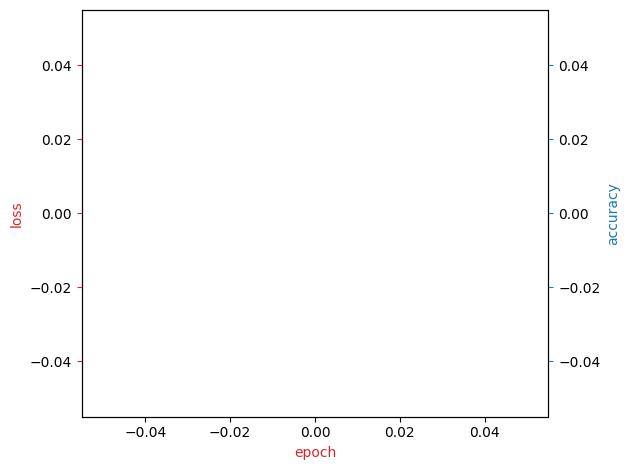

In [131]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

plot(cum_loss_list, acc_epoch)

# 6) CONCEPTS: Decoder, Encoder, Transformer

## Decoder

Important difference between training and predicting using decoders: **Teacher Forcing**:

1. During **prediction/inference** the flow is $$ \text{token}_0 = x_0 \rightarrow \text{input embedding} \rightarrow \text{decoder} \rightarrow \text{contextual representation } \hat{x}_0 \rightarrow \text{output layer with output } z_1 \rightarrow \widehat{\text{word}}_1= \argmax_i(z_1)\,,$$. Then $$ (\hat{x}_1, \widehat{\text{word}}_1 ) \rightarrow \text{input embedding}\,.$$ Recall alo that in general, to the input layer, are sent $(\hat{x}_t,\widehat{\text{word}}_t, \widehat{\text{word}}_{t-1},\ldots,\widehat{\text{word}}_1 )$.

2. During **training** instead, to the input embedding are sent all the true tokens $(x_1,\ldots)$ at the same time, and the loss is computed using $\mathcal{L}(\text{word}_t,\widehat{\text{word}}_t)$. Here $\text{word}_t$ is the target, which is equal to the input $x_t$ (we want to reproduce exactly $x_t$). The problem is that sending all the $x_i$ to the input embedding layer, there can be correlation with future words, in the sense that the algorithm can learn to predict the next word, using the next word instead of the present one. For this reason, within each decoder cell a causal mask mechanism is introduced, so that even if we really send all $(x_1,\ldots)$ at the same time, only the 'not future ones' count:
    - **causal mask mechanism**: like positional encoding, but to the scaled attention scores you add a 'look-ahed mask' which has -inf values for future tokens prediction and zero otherwise. Then the softmax kills the 'future' values

**GPT vs chat GPT**

GPT (Generative Pretrained Transformer) is a decoder-only model because it is trained using a causal language modeling objective, where the goal is to predict the next token in a sequence given the previous tokens. During training, the input sequence is shifted to the right, and the model learns to generate output tokens autoregressively, one at a time. This process allows GPT to generate coherent and contextually relevant text based on the given input prompt.
GPT is a family of large-scale transformer-based language models trained on diverse internet text data. GPT models are designed for a wide range of natural language processing tasks, such as text generation, translation, summarization, and question-answering. They generate responses based on the input text (prompt) but do not maintain a consistent conversation history.

On the other hand, ChatGPT is a fine-tuned version of the GPT model, specifically designed for conversational AI applications. It is trained to maintain a consistent conversation history and generate contextually relevant responses, making it more suitable for chatbot-like interactions. ChatGPT excels at understanding and generating human-like dialogues, providing coherent and engaging responses in a conversational setting.

**SOURCE OF CONFUSION on GPT**

A priori, one expects to use `nn.TransformerDecoderLayer` when constructing a decoder BUT `nn.TransformerDecoderLayer` is built to live in an encoder-decoder system, and for this reason it expects as input both self-attention (outputs of the decoder) AND cross-attention (outputs of the encoder). Thus:
1. If we are building a lonely decoder, which uses self-attention and causal mask WITHOUT cross-attention, we should use `nn.TransformerEncoderLayer`WITH ALSO the specification of the causal mask (defined by hand);
2. If we are building an encoder-decoder system, the decoder has a self-attention mechanism and a cross-attention mechanism. Here we use `nn.TransformerDecoderLayer`, which has (for the self-attention part) an integrated causal mask.

## Encoder

It utilizes **entire sequences** simultaneously, **enhancing comprehension** of the semantic relations, using both sides of the target word (**bidirectional**). It is not used for text generation, but for predicting known words (text summarization, sentiment analysis, question answering). The idea is to mask some known words (15% of the text), or **MLM: Masked language Modelling**, where 'mask' must not be confused with the causal mask of decoder. In the 15%, 12% is replaced with <mask>, 1.5 with random token, and 1.5% remains unchanged.

Usally BERT is **PRETRAINED** using **MLM** and **NSP: Next Sentence Prediction** on vast corpora. The motivation behind unlabeled pretraining transformers is to address the limitations of traditional approaches that require significant amounts of labeled data for each specific task. Pretraining leverages the abundance of **unlabeled text data** available on the internet and facilitates transfer learning, where knowledge learned from one task can be transferred to aid in solving other related tasks.

**NSP**

This is a two classes (y=0/1) classification problem, where we take a complete sequence, we split it in two, take the first part as input and the second as target with y=1. Then give to the model other second parts sentences with y=0. In this way, training the model to the binary classification, BERT learns the logical relation between sentences, and not only among tokens. The complete sentence is modified adding <CLP> at the beginning and <SEP> at the end of the first (input) sentence.

<span style="background-color: yellow"> MLM: understand relations between words </span> and <span style="background-color: yellow">NSP: enables the model to learn sentence-level relationships </span>

## Transformer

It improves the standard language translation (using a RNN) by using enitre sequences at the same time, enhancing spped, efficiency adn understanding of contextual relationship of a word in a sentence, regardless of its lenght. 

# 7) GPT-like Decoder

When training language models, it is generally advisable to use general-domain text. However, in this case, we are using the IMDB dataset, which is well-suited for classification tasks. Also, we use IMDB due to its smaller size and compatibility with machines that have limited RAM.

In [132]:
#running time: 1m 36s

from torchtext.datasets import IMDB # sentiment analysis dataset with (label, text) pairs

train_iter, val_iter = IMDB()

UNK_IDX, PAD_IDX, EOS_IDX = 0, 1, 2
special_symbols = ['<unk>', '<pad>', '<|endoftext|>']

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):

    for _,data_sample in data_iter:
        yield  tokenizer(data_sample)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials = special_symbols, special_first = True)
vocab.set_default_index(UNK_IDX)

Examples:

In [133]:
train_iter, val_iter = IMDB()
iterator = iter(train_iter)

print(next(iterator))

print(next(iterator))

(1, 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between

The following function gives a string of token (importantly with the white spaces), given a list of indices as input:

In [134]:
def index_to_en(ids_list):
    string=''
    for idx in ids_list:
        token = vocab.get_itos()[idx]
        string = string + ' ' +token
    return string.strip()

# index_to_en = lambda seq_en: " ".join([vocab.get_itos()[index] for index in seq_en]) #done by IBM

index_to_en([0,1,2])

'<unk> <pad> <|endoftext|>'

## Creating the src and tgt sentences

To train a regressive model, we want to predict the next word. To this end, given a text, we want to take a sentence and then to take the same sentence but shifted of one position. For example, we want to create:

```
src:  ['around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants']
tgt:  ['a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to']
```

so that wi give to the model $x_0$ 'around', and it predicts $\text{word}_1$ which must be confronted with 'a':

In [135]:
def get_sample(block_size, text): # the src_ and tgt_sequence will be of block_size lenght
                                  # text is a tokenized text
    sample_leg = len(text)
    random_sample_stop = sample_leg - block_size

    # Check if a random sample can be taken (if the text is longer than block_size)
    if random_sample_stop >= 1:
        # Randomly select a starting point for the sample
        random_start = torch.randint(low=0, high = random_sample_stop, size=(1,)).item()
        # Define the endpoint of the sample
        stop = random_start + block_size

        # Create the input and target sequences
        src_sequence = text[random_start:stop]
        tgt_sequence= text[random_start + 1:stop + 1]

    # Handle the case where the text length is exactly equal or less the block size
    elif random_sample_stop <= 0:
        # Start from the beginning and use the entire text
        random_start = 0
        stop = sample_leg
        src_sequence= text[random_start:stop]
        tgt_sequence = text[random_start + 1:stop]
        # Append an empty string to maintain sequence alignment
        tgt_sequence.append( '<|endoftext|>')

    return src_sequence, tgt_sequence

example of usage:

In [136]:
sentiment, text = next(iterator)
text = tokenizer(text)
block_size=30
src_sequences, tgt_sequence=get_sample(block_size, text)

print("src: ",src_sequences)
print("tgt: ",tgt_sequence)

src:  ['comes', 'away', 'with', 'no', 'new', 'perspectives', '(', 'unless', 'one', 'comes', 'up', 'with', 'one', 'while', 'one', "'", 's', 'mind', 'wanders', ',', 'as', 'it', 'will', 'invariably', 'do', 'during', 'this', 'pointless', 'film', ')']
tgt:  ['away', 'with', 'no', 'new', 'perspectives', '(', 'unless', 'one', 'comes', 'up', 'with', 'one', 'while', 'one', "'", 's', 'mind', 'wanders', ',', 'as', 'it', 'will', 'invariably', 'do', 'during', 'this', 'pointless', 'film', ')', '.']


## Collate function and Loader

In [137]:
BLOCK_SIZE=30

UNK_IDX, PAD_IDX, EOS_IDX = 0, 1, 2

def collate_batch(batch):
    src_batch, tgt_batch = [], [] #the sum of lists
    for _sentiment,_textt in batch:

      src_sequence, tgt_sequence = get_sample(BLOCK_SIZE, tokenizer(_textt)) #src_sequence, tgt_sequence are list of tokens

      src_sequence=vocab(src_sequence) #converted to indices through the vocab
      tgt_sequence=vocab(tgt_sequence) #converted to indices through the vocab

      src_sequence = torch.tensor(src_sequence, dtype=torch.int64)
      tgt_sequence = torch.tensor(tgt_sequence, dtype=torch.int64)

      src_batch.append(src_sequence)
      tgt_batch.append(tgt_sequence)


    src_batch = pad_sequence(src_batch, padding_value = PAD_IDX, batch_first = False)
    tgt_batch = pad_sequence(tgt_batch, padding_value = PAD_IDX, batch_first = False)

    return src_batch.to(device), tgt_batch.to(device)

BATCH_SIZE = 1

train_iter, val_iter = IMDB()

train_dataloader = DataLoader(train_iter, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)
val_dataloader= DataLoader(val_iter , batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)

## Masking

1. The first line generates a square matrix with True in the upper triangular part (diagonal included!), and then transpose it, and then the .float() inserts 0 on the false. So at the end of the first line we have
```
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
```
2. The second line replace the 0 in mask with -inf and the 1 with 0, this getting
```
tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])
```

In [138]:
def generate_square_subsequent_mask(size, device = device):
    mask = (torch.triu(torch.ones((size, size), device=device)) == 1).transpose(0, 1).float() #
    mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

Next, given a sequence coming from a loader (which has dimension ([BLOCK_SIZE, BATCH_SIZE])), we want to apply the mask to it. Thus we create a src_mask with dimension BLOCK_SIZE x BLOCK_SIZE (that will be passed directly in the model nn.TrasformerDecoderLayer, without adding manually this to the input) and also a src_padding_mask, because our sentences are padded to the right, and the padding must not influence the attention mechanism. For this reason, we will pass to the nn.TrasformerDecoderLayer src_padding_mask:

In [139]:
def create_mask(src, device = device):
    src_seq_len = src.shape[0] # =BLOCK_SIZE

    src_mask = generate_square_subsequent_mask(src_seq_len)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)

    return src_mask , src_padding_mask

#usage example
dataset = iter(train_dataloader)
src, tgt = next(dataset)
src_mask,src_padding_mask = create_mask(src)
src_mask.shape


torch.Size([30, 30])

## Positional encoding

Second version of the positional encoding:

In [140]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()

        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

## My GPT model

If confused by the presence of encoder layers, give a look to **SOURCE OF CONFUSION on GPT** in 6). The decoder function is exactly equal to the forward one. The difference is that the forward method is used automatically in training, and we will use the encoder function to do inference/text generation:

In [141]:
class CustomGPTModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads, num_of_decoder_layers, max_seq_len=500, dropout=0.1):
        super().__init__()
        self.embed_size = embed_size


        #input layer for embedding and sum with positional encoding
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout = dropout)

        # Remaining layers are part of the TransformerDecoder
        encoder_layers = nn.TransformerEncoderLayer(d_model = embed_size, nhead = num_heads, dropout = dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers = num_of_decoder_layers)

        # output layer for prediction
        self.lm_head = nn.Linear(embed_size, vocab_size)

        self.init_weights()

    def init_weights(self):
      for p in self.parameters():
          if p.dim() > 1:
              nn.init.xavier_uniform_(p)


    def forward(self, x, src_mask = None, src_padding_mask = None):

        if src_mask is None and src_padding_mask is None:

            src_mask, src_padding_mask = create_mask(x)

        seq_length = x.size(0)

        # Add positional embeddings to the input embeddings
        x = self.embed(x)* math.sqrt(self.embed_size) #src = self.embedding(src) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)



        output = self.transformer_encoder(x, mask=src_mask, src_key_padding_mask = src_padding_mask)
        logits = self.lm_head(output)

        return logits

In [142]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

model = CustomGPTModel(embed_size = emsize, num_heads = nhead,
                        num_of_decoder_layers = nlayers, vocab_size = ntokens,
                        dropout = dropout).to(device)

## Text generation

The text generation needs a starting point, which is called prompt. This prompt should be tokenized, should not be None and should not be too long:

In [143]:
def indicized_prompt(prompt, block_size=BLOCK_SIZE):
    # Handle None prompt
    while prompt is None:
        prompt = input("Sorry, prompt cannot be empty. Please enter a valid prompt: ")

    tokens = tokenizer(prompt)
    number_of_tokens = len(tokens)

    # Handle long prompts
    if number_of_tokens > block_size:
        tokens = tokens[-block_size:]  # Keep last block_size characters

    prompt_indices = vocab(tokens)

    prompt_encoded = torch.tensor(prompt_indices, dtype=torch.int64).reshape(-1, 1)
    return prompt_encoded

Usage example:

In [144]:
model.eval() #to deactivate dropout
prompt_encoded = indicized_prompt("This is a prompt to get model generate next words.").to(device) #11 tokens
logits = model(prompt_encoded, src_mask = None).to(device)
logits.shape #torch.Size([11, 1, 100685])
logits = logits.transpose(0, 1) #torch.Size([1, 11, 100685])
logits.shape
logit_preiction =logits[:,-1]
_, next_word_index = torch.max(logit_preiction, dim=1)
next_word_index

index_to_en(next_word_index)

'paterfamilias'

Then we can define a function that, given the indicized_prompt, do generation

In [145]:
def generate(model, prompt=None, max_new_tokens = 500, block_size = BLOCK_SIZE, vocab = vocab, tokenizer = tokenizer):
    model.eval()
    model.to(device)
    prompt_encoded = indicized_prompt(prompt).to(device)
    tokens = []

    # Generate new tokens up to max_new_tokens
    for _ in range(max_new_tokens):
        # Decode the encoded prompt using the model's decoder
        logits = model(prompt_encoded,src_mask=None,src_padding_mask=None)

        # Transpose the logits to bring the sequence length to the first dimension
        logits = logits.transpose(0, 1)

        # Select the logits of the last token in the sequence
        logit_prediction = logits[:, -1]

        # Choose the most probable next token from the logits(greedy decoding)
        next_token_encoded = torch.argmax(logit_prediction, dim=-1).reshape(-1, 1)

        # If the next token is the end-of-sequence (EOS) token, stop generation
        if next_token_encoded.item() == EOS_IDX:
            break

        # Append the next token to the prompt_encoded and keep only the last 'block_size' tokens
        prompt_encoded = torch.cat((prompt_encoded, next_token_encoded), dim=0)[-block_size:]

        # Convert the next token index to a token string using the vocabulary
        # Move the tensor back to CPU for vocab lookup if needed
        token_id = next_token_encoded.to('cpu').item()
        tokens.append(vocab.get_itos()[token_id])

    # Join the generated tokens into a single string and return
    return ' '.join(tokens)

The generation, of course, is awful because we did not train the model:

In [146]:
generate(model,prompt="this is the beginning of",max_new_tokens=30,vocab=vocab,tokenizer=tokenizer)

'pseuds bulb-lights bulb-lights bulb-lights bulb-lights enyard enyard paterfamilias graduating pain-in-the-butt pain-in-the-butt calista pain-in-the-butt pain-in-the-butt pain-in-the-butt early-century $23 $23 spivs predicable calista calista calista calista calista calista calista calista calista calista'

## Accuracy

In [147]:
loss_fn = CrossEntropyLoss(ignore_index=PAD_IDX)

def evaluate(model: nn.Module, eval_data) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for src,tgt in eval_data:
            tgt = tgt.to(device)
            #seq_len = src.size(0)
            logits = model(src)
            total_loss +=  loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1)).item()
    return total_loss / (len(list(eval_data)) - 1)

In [148]:
#evaluate(model,val_dataloader)

## Training

In [149]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.01, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10000, gamma=0.9)

def train(model: nn.Module,train_data) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 10000
    start_time = time.time()

    num_batches = len(list(train_data)) //BLOCK_SIZE
    for batch,srctgt in enumerate(train_data):
        src= srctgt[0]
        tgt= srctgt[1]
        logits = model(src,src_mask=None)
        logits_flat = logits.reshape(-1, logits.shape[-1])
        loss = loss_fn(logits_flat, tgt.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        total_loss += loss.item()

        if (batch % log_interval == 0 and batch > 0) or batch==42060:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            #cur_loss = total_loss / log_interval
            cur_loss = total_loss / batch
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch//BLOCK_SIZE:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.4f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            start_time = time.time()

    return total_loss

It works, but it is commented for time saving

In [150]:
best_val_loss = float('inf')
epochs = 1
Train_losses= []
Val_losses = []
# for epoch in tqdm(range(1, epochs + 1)):
#     epoch_start_time = time.time()
#     train_loss = train(model,train_dataloader)
#     val_loss = evaluate(model, val_dataloader)
#     val_ppl = math.exp(val_loss)
#     Train_losses.append(train_loss)
#     Val_losses.append(val_loss)

#     elapsed = time.time() - epoch_start_time
#     print('-' * 89)
#     print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
#         f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
#     print('-' * 89)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'model_best_val_loss.pt')

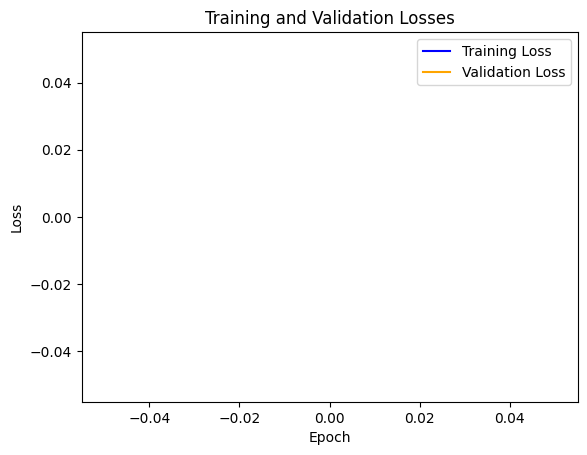

In [151]:
# Calculate the number of epochs (assuming the lengths of train_losses and val_losses are equal)
num_epochs = len(Train_losses)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the training losses
ax.plot(range(num_epochs), Train_losses, label='Training Loss', color='blue')

# Plot the validation losses
ax.plot(range(num_epochs), Val_losses, label='Validation Loss', color='orange')

# Set the x-axis label
ax.set_xlabel('Epoch')

# Set the y-axis label
ax.set_ylabel('Loss')

# Set the title of the plot
ax.set_title('Training and Validation Losses')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

## Using Hugging-Face GPT2

In [152]:
tokenizer1 = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

input_text = "I do not love my family"

# Tokenize the input text and prepare the input for the model
input_ids = tokenizer1.encode(input_text, return_tensors="pt")

# Generate text using the model
# Set the desired length of the generated text (max_length),
# and other generation parameters like temperature, top_k, and top_p
max_length = 15
temperature = 0.7
top_k = 50
top_p = 0.95

generated_ids = model.generate(
    input_ids,
    max_length=max_length,
    temperature=temperature,
    top_k=top_k,
    top_p=top_p,
    pad_token_id=tokenizer1.eos_token_id,
)

# Decode the generated text
generated_text = tokenizer1.decode(generated_ids[0], skip_special_tokens = True)

# Print the input prompt and the generated text
print(f"Input: {input_text}")
print(f"Generated Text: {generated_text}")

Input: I do not love my family
Generated Text: I do not love my family, but I love my family. I love


# 8) BERT-like Encoder

## Data Preparation

We start with the usual things, as in 7), but with more special symbols:

In [153]:
from torchtext.datasets import IMDB

train_iter, test_iter = IMDB(split=('train', 'test'))
all_data_iter = chain(train_iter, test_iter)

PAD_IDX,CLS_IDX, SEP_IDX,  MASK_IDX,UNK_IDX= 0, 1, 2, 3, 4
special_symbols = ['[PAD]','[CLS]', '[SEP]','[MASK]','[UNK]']

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):

    for label, data_sample in data_iter:
        yield  tokenizer(data_sample)

vocab = build_vocab_from_iterator(yield_tokens(all_data_iter), specials = special_symbols, special_first = True) #build vocab from all data
vocab.set_default_index(UNK_IDX)

VOCAB_SIZE=len(vocab)
print('Size of vocabulary:', VOCAB_SIZE)

Size of vocabulary: 125092


In [154]:
def index_to_en(ids_list): #index_to_english
    string=''
    for idx in ids_list:
        token = vocab.get_itos()[idx]
        string = string + ' ' +token
    return string.strip()

all_data_iter = chain(train_iter, test_iter)

fifth_item_tokens = next(islice(yield_tokens(all_data_iter), 5, None))
print(fifth_item_tokens[:20])

['i', 'would', 'put', 'this', 'at', 'the', 'top', 'of', 'my', 'list', 'of', 'films', 'in', 'the', 'category', 'of', 'unwatchable', 'trash', '!', 'there']


Then we want to prepare data for MLM and NSP. We define a MLM and a NSP function, which at the end will be unified. Notice that MLM is used also in NSP.

### MLM (Masked Language Modelling)

The following functions decide whether each token in a sequence should be masked, left unchanged, or replaced with a random token. This process is essential for training the model to predict masked words based on their context.

We want to achieve something like this
```
original_input is:  'The sun sets behind the distant mountains'
BERT_input is:  [['[MASK]','sun','sets','behind','the','[MASK]','mountains','.']]
BERT_label is:  [['the','[PAD]','[PAD]','[PAD]','[PAD]','casual token','[PAD]','[PAD]']]
```
and in particular

- If the token is not substituted the corresponding label is [PAD]:
- If it is masked, the token is substituted with [MASK] there are two possibilities:
    1. Or the label is the original token:
    2. Or with a casual token.

So we prepare a function for masking a single token, and then apply to a whole tokenized sequence in the subsequent function:

In [155]:
def bernoulli_true_false(probability):
    # Create a Bernoulli distribution with probability p
    bernoulli_dist = torch.distributions.Bernoulli(torch.tensor([probability]))
    # Sample from this distribution and convert 1 to True and 0 to False
    return bernoulli_dist.sample().item() == 1

bernoulli_true_false(0.7)

False

In [156]:
def Masking(token):
    
    mask = bernoulli_true_false(0.2) # Decide whether to mask this token (20% chance); this is True or False

    if mask is False: # If mask is False, return with '[PAD]' label
        token_ = token
        mask_label = '[PAD]'

    random_opp = bernoulli_true_false(0.5)
    random_swich = bernoulli_true_false(0.5)

    if mask is True and random_opp is True and random_swich is True: # Replace the token with '[MASK]' and set label to a random token
        token_ = '[MASK]'
        mask_label = index_to_en(torch.randint(0, VOCAB_SIZE, (1,)))
    
    elif mask is True and random_opp is True and random_swich is False: # Leave the token unchanged and set label to the same token
        token_ = token
        mask_label = token

    else: # Replace the token with '[MASK]' and set label to the original token
        token_ = '[MASK]'
        mask_label = token

    return token_, mask_label

def BERT_Masking(token):
    # Decide if this token should be masked (15% chance)
    apply_mask = bernoulli_true_false(0.15)

    if not apply_mask:
        return token, '[PAD]'

    # Choose the masking strategy
    rand = torch.rand(1).item()

    if rand < 0.8:
        # 80% of the time → [MASK] in input, original token in label
        return '[MASK]', token
    elif rand < 0.9:
        # 10% of the time → original token in input, original token in label
        return token, token
    else:
        # 10% of the time → random token in input, original token in label
        random_index = torch.randint(0, VOCAB_SIZE, (1,))
        return index_to_en(random_index), token


In [157]:
def prepare_for_mlm(tokens, include_raw_tokens = False):
    raw_tokens_list = []  # List to store raw tokens if needed
    bert_input = []  # List to store sentences processed for BERT's MLM
    bert_label = []  # List to store labels for each token (mask, random, or unchanged)
    current_raw_tokens = []
    current_bert_input = []
    current_bert_label = []

    for token in tokens:
        masked_token, mask_label = Masking(token)
        masked_token, mask_label = BERT_Masking(token)

        current_bert_input.append(masked_token)
        current_bert_label.append(mask_label)

        if include_raw_tokens is True:
            current_raw_tokens.append(token)

        # Check if the token is a sentence delimiter (., ?, !)
        if token in ['.', '?', '!']:
            # If current sentence has more than two tokens, consider it a valid sentence
            if len(current_bert_input) > 2:
                bert_input.append(current_bert_input)
                bert_label.append(current_bert_label)
                # If including raw tokens, add the current list of raw tokens to the raw tokens list
                if include_raw_tokens:
                    raw_tokens_list.append(current_raw_tokens)

                # Reset the lists for the next sentence
                current_bert_input = []
                current_bert_label = []
                current_raw_tokens = []
            else:
                # If the current sentence is too short, discard it and reset lists
                current_bert_input = []
                current_bert_label = []
                current_raw_tokens = []

    # Add any remaining tokens as a sentence if there are any
    if current_bert_input:
        bert_input.append(current_bert_input)
        bert_label.append(current_bert_label)
        if include_raw_tokens:
            raw_tokens_list.append(current_raw_tokens)

    # Return the prepared lists for BERT's MLM training
    return (bert_input, bert_label, raw_tokens_list) if include_raw_tokens else (bert_input, bert_label)

Usage example:

In [158]:
original_input = "The sun sets behind the distant mountains."
tokens = tokenizer(original_input)

bert_input, bert_label, raw_tokens_list = prepare_for_mlm(tokens, include_raw_tokens = True)

print('raw:',raw_tokens_list)
print('bert_input is:',bert_input)
print('bert_label is:',bert_label)

raw: [['the', 'sun', 'sets', 'behind', 'the', 'distant', 'mountains', '.']]
bert_input is: [['the', 'sun', '[MASK]', 'behind', '[MASK]', 'distant', 'mountains', '.']]
bert_label is: [['[PAD]', '[PAD]', 'sets', '[PAD]', 'the', '[PAD]', '[PAD]', '[PAD]']]


### NSP (Next Sequence Predictions)

We want to achieve something like this
```
BERT Input:
[['[CLS]', 'she', 'enjoys', 'reading', 'books', '[SEP]'], ['he', 'likes', 'playing', 'guitar', '[SEP]']]
BERT Label:
[['[PAD]', '[PAD]', '[PAD]', '[PAD]', 'books', '[PAD]'], ['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']]
Is Next:  [1]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
BERT Input:
[['[CLS]', 'he', 'likes', 'playing', 'guitar', '[SEP]'], ['i', 'love', 'apples', '[SEP]']]
BERT Label:
[['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'], ['[PAD]', 'love', '[PAD]', '[PAD]']]
Is Next:  [0]
```

In [159]:
def process_for_nsp(input_sentences, input_masked_labels): # input_sentences = list of tokenized sentences
                                                            # input_masked_labels = corresponding label masked list 

    if len(input_sentences) < 2:
       raise ValueError("Must have at least two sentences.")


    # Verify that both input lists are of the same length and have a sufficient number of sentences
    if len(input_sentences) != len(input_masked_labels):
        raise ValueError("Both lists must have the same number of items.")

    bert_input = []
    bert_label = []
    is_next = []

    available_indices = list(range(len(input_sentences)))

    while len(available_indices) >= 2:
        if random.random() < 0.5:
            # Choose two consecutive sentences to simulate the 'next sentence' scenario
            index = random.choice(available_indices[:-1])  # Exclude the last index
            # append list and add  '[CLS]' and  '[SEP]' tokens
            bert_input.append([['[CLS]']+input_sentences[index]+ ['[SEP]'],input_sentences[index + 1]+ ['[SEP]']])
            bert_label.append([['[PAD]']+input_masked_labels[index]+['[PAD]'], input_masked_labels[index + 1]+ ['[PAD]']])
            is_next.append(1)  # Label 1 indicates these sentences are consecutive

            # Remove the used indices
            available_indices.remove(index)
            if index + 1 in available_indices:
                available_indices.remove(index + 1)
        else:
            # Choose two random distinct sentences to simulate the 'not next sentence' scenario
            indices = random.sample(available_indices, 2)
            bert_input.append([['[CLS]']+input_sentences[indices[0]]+['[SEP]'],input_sentences[indices[1]]+ ['[SEP]']])
            bert_label.append([['[PAD]']+input_masked_labels[indices[0]]+['[PAD]'], input_masked_labels[indices[1]]+['[PAD]']])
            is_next.append(0)  # Label 0 indicates these sentences are not consecutive

            # Remove the used indices
            available_indices.remove(indices[0])
            available_indices.remove(indices[1])



    return bert_input, bert_label, is_next

Usage example:

In [160]:
#flatten the tensor
flatten = lambda l: [item for sublist in l for item in sublist]
# Sample input sentences
input_sentences = [["i", "love", "apples"], ["she", "enjoys", "reading", "books"], ["he", "likes", "playing", "guitar"]]
# Create masked labels for the sentences
input_masked_labels=[]
for sentence in input_sentences:
  _, current_masked_label= prepare_for_mlm(sentence, include_raw_tokens = False)
  input_masked_labels.append(flatten(current_masked_label))
# Create NSP pairs and labels
random.seed(100)
bert_input, bert_label, is_next = process_for_nsp(input_sentences, input_masked_labels)

# Print the output
print("BERT Input:")
for pair in bert_input:
    print(pair)
print("BERT Label:")
for pair in bert_label:
    print(pair)
print("Is Next: ", is_next)
print("-"*200)
random.seed(1000)
bert_input, bert_label, is_next = process_for_nsp(input_sentences, input_masked_labels)

# Print the output
print("BERT Input:")
for pair in bert_input:
    print(pair)
print("BERT Label:")
for pair in bert_label:
    print(pair)
print("Is Next: ", is_next)

BERT Input:
[['[CLS]', 'she', 'enjoys', 'reading', 'books', '[SEP]'], ['he', 'likes', 'playing', 'guitar', '[SEP]']]
BERT Label:
[['[PAD]', '[PAD]', '[PAD]', '[PAD]', 'books', '[PAD]'], ['[PAD]', '[PAD]', '[PAD]', 'guitar', '[PAD]']]
Is Next:  [1]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
BERT Input:
[['[CLS]', 'he', 'likes', 'playing', 'guitar', '[SEP]'], ['i', 'love', 'apples', '[SEP]']]
BERT Label:
[['[PAD]', '[PAD]', '[PAD]', '[PAD]', 'guitar', '[PAD]'], ['[PAD]', '[PAD]', '[PAD]', '[PAD]']]
Is Next:  [0]


### Final preparation and dataset creation

`prepare_bert_final_inputs` consolidates the prepared data for MLM and NSP into a format suitable for BERT training, including converting tokens to indices, padding sequences for uniform length, and generating segment labels to distinguish between pairs of sentences. This function is the final step in preparing data for BERT, ensuring it is in the correct format for effective model training.

In [161]:
def prepare_bert_final_inputs(bert_inputs, bert_labels, is_nexts,to_tenor=True):
    """
    Prepare the final input lists for BERT training.
    """
    def zero_pad_list_pair(pair_, pad='[PAD]'):
        pair=deepcopy(pair_)
        max_len = max(len(pair[0]), len(pair[1]))
        #append [PAD] to each sentence in the pair till the maximum length reaches
        pair[0].extend([pad] * (max_len - len(pair[0])))
        pair[1].extend([pad] * (max_len - len(pair[1])))
        return pair[0], pair[1]

    #flatten the tensor
    flatten = lambda l: [item for sublist in l for item in sublist]
    #transform tokens to vocab indices
    tokens_to_index=lambda tokens: [vocab[token] for token in tokens]

    bert_inputs_final, bert_labels_final, segment_labels_final, is_nexts_final = [], [], [], []

    for bert_input, bert_label,is_next in zip(bert_inputs, bert_labels,is_nexts):
        # Create segment labels for each pair of sentences
        segment_label = [[1] * len(bert_input[0]), [2] * len(bert_input[1])]

        # Zero-pad the bert_input and bert_label and segment_label
        bert_input_padded = zero_pad_list_pair(bert_input)
        bert_label_padded = zero_pad_list_pair(bert_label)
        segment_label_padded = zero_pad_list_pair(segment_label,pad=0)

        #convert to tensors
        if to_tenor:

            # Flatten the padded inputs and labels, transform tokens to their corresponding vocab indices, and convert them to tensors
            bert_inputs_final.append(torch.tensor(tokens_to_index(flatten(bert_input_padded)),dtype=torch.int64))
            #bert_labels_final.append(torch.tensor(tokens_to_index(flatten(bert_label_padded)),dtype=torch.int64))
            bert_labels_final.append(torch.tensor(tokens_to_index(flatten(bert_label_padded)),dtype=torch.int64))
            segment_labels_final.append(torch.tensor(flatten(segment_label_padded),dtype=torch.int64))
            is_nexts_final.append(is_next)

        else:
          # Flatten the padded inputs and labels
            bert_inputs_final.append(flatten(bert_input_padded))
            bert_labels_final.append(flatten(bert_label_padded))
            segment_labels_final.append(flatten(segment_label_padded))
            is_nexts_final.append(is_next)

    return bert_inputs_final, bert_labels_final, segment_labels_final, is_nexts_final

In [162]:
bert_inputs_final, bert_labels_final, segment_labels_final, is_nexts_final=prepare_bert_final_inputs(bert_input, bert_label, is_next,to_tenor=True)
torch.set_printoptions(linewidth=10000)# this assures that whole output is printed in one line
print("input:\t\t",bert_input,"\ninputs_final:\t",bert_inputs_final,"\nbert labels final:\t",bert_labels_final,"\nsegment labels final:\t",segment_labels_final,"\nis nexts final:\t",is_nexts_final)

input:		 [[['[CLS]', 'he', 'likes', 'playing', 'guitar', '[SEP]'], ['i', 'love', 'apples', '[SEP]']]] 
inputs_final:	 [tensor([    1,    35,  1172,   409,  5184,     2,    16,   138, 14585,     2,     0,     0])] 
bert labels final:	 [tensor([   0,    0,    0,    0, 5184,    0,    0,    0,    0,    0,    0,    0])] 
segment labels final:	 [tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0])] 
is nexts final:	 [0]


Then we create a csv final which contains all this. This will be the dataset for training the BERT model

Run one time!

In [163]:
# csv_file_path ='train_bert_data_new.csv'
# with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
#     csv_writer = csv.writer(file)
#     csv_writer.writerow(['Original Text', 'BERT Input', 'BERT Label', 'Segment Label', 'Is Next'])

#     # Wrap train_iter with tqdm for a progress bar
#     for n, (_, sample) in enumerate(tqdm(train_iter, desc="Processing samples")):
#         # Tokenize the sample input
#         tokens = tokenizer(sample)
#         # Create MLM inputs and labels
#         bert_input, bert_label = prepare_for_mlm(tokens, include_raw_tokens = False)
#         if len(bert_input) < 2:
#             continue
#         # Create NSP pairs, token labels, and is_next label
#         bert_inputs, bert_labels, is_nexts = process_for_nsp(bert_input, bert_label)
#         # add zero-paddings, map tokens to vocab indices and create segment labels
#         bert_inputs, bert_labels, segment_labels, is_nexts = prepare_bert_final_inputs(bert_inputs, bert_labels, is_nexts)
#         # convert tensors to lists, convert lists to JSON-formatted strings
#         for bert_input, bert_label, segment_label, is_next in zip(bert_inputs, bert_labels, segment_labels, is_nexts):
#             bert_input_str = json.dumps(bert_input.tolist())
#             bert_label_str = json.dumps(bert_label.tolist())
#             segment_label_str = ','.join(map(str, segment_label.tolist()))
#             # Write the data to a CSV file row-by-row
#             csv_writer.writerow([sample, bert_input_str, bert_label_str, segment_label_str, is_next])

## Pre-training

In [164]:
!wget -O BERT_dataset.zip https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bZaoQD52DcMpE7-kxwAG8A.zip
!unzip -y BERT_dataset.zip

--2025-07-28 10:47:57--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bZaoQD52DcMpE7-kxwAG8A.zip
Risoluzione di cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connessione a cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 88958506 (85M) [application/zip]
Salvataggio in: «BERT_dataset.zip»

BERT_dataset.zip    100%[===================>]  84.84M  1.09MB/s    in 39s     

2025-07-28 10:48:37 (2.20 MB/s) - «BERT_dataset.zip» salvato [88958506/88958506]

UnZip 6.00 of 20 April 2009, by Info-ZIP, with modifications by Apple Inc.
Please report bugs to Apple.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
 

In [165]:
class BERTCSVDataset(Dataset):
    def __init__(self, filename):
        self.data = pd.read_csv(filename)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        try:
            
            bert_input = torch.tensor(json.loads(row['BERT Input']), dtype=torch.long)
            bert_label = torch.tensor(json.loads(row['BERT Label']), dtype=torch.long)
            segment_label = torch.tensor([int(x) for x in row['Segment Label'].split(',')], dtype=torch.long)
            is_next = torch.tensor(row['Is Next'], dtype=torch.long)
            original_text = row['Original Text']  # If you want to use it
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for row {idx}: {e}")
            print("BERT Input:", row['BERT Input'])
            print("BERT Label:", row['BERT Label'])
            # Handle the error, e.g., by skipping this row or using default values
            return None  # or some default values

            # Tokenizing the original text with BERT
        encoded_input = self.tokenizer.encode_plus(
            original_text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        return(bert_input, bert_label, segment_label, is_next, input_ids, attention_mask, original_text)

### Collate function and DataLoader

In [166]:
PAD_IDX = 0
def collate_batch(batch):

   
    bert_inputs_batch, bert_labels_batch, segment_labels_batch, is_nexts_batch,input_ids_batch,attention_mask_batch,original_text_battch = [], [], [], [],[],[],[]

    for bert_input, bert_label, segment_label, is_next,input_ids,attention_mask,original_text in batch:
        # Convert each sequence to a tensor and append to the respective list
        bert_inputs_batch.append(torch.tensor(bert_input, dtype=torch.long))
        bert_labels_batch.append(torch.tensor(bert_label, dtype=torch.long))
        segment_labels_batch.append(torch.tensor(segment_label, dtype=torch.long))
        is_nexts_batch.append(is_next)
        input_ids_batch.append(input_ids)
        attention_mask_batch.append(attention_mask)
        original_text_battch.append(original_text)

    # Pad the sequences in the batch
    bert_inputs_final = pad_sequence(bert_inputs_batch, padding_value=PAD_IDX, batch_first=False)
    bert_labels_final = pad_sequence(bert_labels_batch, padding_value=PAD_IDX, batch_first=False)
    segment_labels_final = pad_sequence(segment_labels_batch, padding_value=PAD_IDX, batch_first=False)
    is_nexts_batch = torch.tensor(is_nexts_batch, dtype=torch.long)

    return bert_inputs_final, bert_labels_final, segment_labels_final, is_nexts_batch

BATCH_SIZE = 2

train_dataset_path = './bert_dataset/bert_train_data.csv'
test_dataset_path = './bert_dataset/bert_test_data.csv'

train_dataset = BERTCSVDataset(train_dataset_path)
test_dataset = BERTCSVDataset(test_dataset_path)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

FileNotFoundError: [Errno 2] No such file or directory: './bert_dataset/bert_train_data.csv'

### The model

In [ ]:
EMBEDDING_DIM = 10

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Define the PositionalEncoding class as a PyTorch module for adding positional information to token embeddings
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        # Create a positional encoding matrix as per the Transformer paper's formula
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: torch.Tensor):
        # Apply the positional encodings to the input token embeddings

        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [ ]:
class BERTEmbedding (nn.Module):

    def __init__(self, vocab_size, emb_size ,dropout=0.1,train=True):

        super().__init__()

        self.token_embedding = TokenEmbedding( vocab_size,emb_size )
        self.positional_encoding = PositionalEncoding(emb_size,dropout)
        self.segment_embedding = nn.Embedding(3, emb_size)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, bert_inputs, segment_labels=False):
        my_embeddings=self.token_embedding(bert_inputs)
        if self.train:
          x = self.dropout(my_embeddings + self.positional_encoding(my_embeddings) + self.segment_embedding(segment_labels))
        else:
          x = my_embeddings + self.positional_encoding(my_embeddings)

        return x

In [ ]:
class BERT(torch.nn.Module):
    
    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        vocab_size: The size of the vocabulary.
        d_model: The size of the embeddings (hidden size).
        n_layers: The number of Transformer layers.
        heads: The number of attention heads in each Transformer layer.
        dropout: The dropout rate applied to embeddings and Transformer layers.
        """
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # Embedding layer that combines token embeddings and segment embeddings
        self.bert_embedding = BERTEmbedding(vocab_size, d_model, dropout)

        # Transformer Encoder layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, dropout=dropout,batch_first=False)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)

        # Linear layer for Next Sentence Prediction
        self.nextsentenceprediction = nn.Linear(d_model, 2)

        # Linear layer for Masked Language Modeling
        self.masked_language = nn.Linear(d_model, vocab_size)

    def forward(self, bert_inputs, segment_labels):
        """
        bert_inputs: Input tokens.
        segment_labels: Segment IDs for distinguishing different segments in the input.
        mask: Attention mask to prevent attention to padding tokens.

        return: Predictions for next sentence task and masked language modeling task.
        """

        padding_mask = (bert_inputs == PAD_IDX).transpose(0, 1)
        # Generate embeddings from input tokens and segment labels
        my_bert_embedding = self.bert_embedding(bert_inputs, segment_labels)

        # Pass embeddings through the Transformer encoder
        transformer_encoder_output = self.transformer_encoder(my_bert_embedding,src_key_padding_mask=padding_mask)


        next_sentence_prediction = self.nextsentenceprediction(transformer_encoder_output[ 0,:])
        

        # Masked Language Modeling: Predict all tokens in the sequence
        masked_language = self.masked_language(transformer_encoder_output)

        return  next_sentence_prediction, masked_language

In [ ]:
EMBEDDING_DIM = 10

# Define parameters
vocab_size = 147161  # Replace VOCAB_SIZE with your vocabulary size
d_model = EMBEDDING_DIM  # Replace EMBEDDING_DIM with your embedding dimension
n_layers = 2  # Number of Transformer layers
initial_heads = 12 # Initial number of attention heads
initial_heads = 2
# Ensure the number of heads is a factor of the embedding dimension
heads = initial_heads - d_model % initial_heads

dropout = 0.1  # Dropout rate

# Create an instance of the BERT model
model = BERT(vocab_size, d_model, n_layers, heads, dropout)

### Accuracy

In [ ]:
def evaluate(dataloader=test_dataloader, model=model, loss_fn_mlm=loss_fn_mlm, loss_fn_nsp=loss_fn_nsp, device=device):
    model.eval()  # Turn off dropout and other training-specific behaviors

    total_loss = 0
    total_next_sentence_loss = 0
    total_mask_loss = 0
    total_batches = 0
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for batch in dataloader:
            bert_inputs, bert_labels, segment_labels, is_nexts = [b.to(device) for b in batch]

            # Forward pass
            next_sentence_prediction, masked_language = model(bert_inputs, segment_labels)

            # Calculate loss for next sentence prediction
            # Ensure is_nexts is of the correct shape for CrossEntropyLoss
            next_loss = loss_fn_nsp(next_sentence_prediction, is_nexts.view(-1))

            # Calculate loss for predicting masked tokens
            # Flatten both masked_language predictions and bert_labels to match CrossEntropyLoss input requirements
            mask_loss = loss_fn_mlm(masked_language.view(-1, masked_language.size(-1)), bert_labels.view(-1))

            # Sum up the two losses
            loss = next_loss + mask_loss
            if torch.isnan(loss):
                continue
            else:
                total_loss += loss.item()
                total_next_sentence_loss += next_loss.item()
                total_mask_loss += mask_loss.item()
                total_batches += 1

    avg_loss = total_loss / (total_batches + 1)
    avg_next_sentence_loss = total_next_sentence_loss / (total_batches + 1)
    avg_mask_loss = total_mask_loss / (total_batches + 1)

    print(f"Average Loss: {avg_loss:.4f}, Average Next Sentence Loss: {avg_next_sentence_loss:.4f}, Average Mask Loss: {avg_mask_loss:.4f}")
    return avg_loss

NameError: name 'loss_fn_mlm' is not defined

### Training

In [ ]:
def Masking(token):
    
    mask = bernoulli_true_false(0.2) # Decide whether to mask this token (20% chance); this is True or False

    if mask is False: # If mask is False, return with '[PAD]' label
        token_ = token
        mask_label = '[PAD]'

    random_opp = bernoulli_true_false(0.5)
    random_swich = bernoulli_true_false(0.5)

    if mask is True and random_opp is True and random_swich is True: # Replace the token with '[MASK]' and set label to a random token
        token_ = '[MASK]'
        mask_label = index_to_en(torch.randint(0, VOCAB_SIZE, (1,)))
    
    elif mask is True and random_opp is True and random_swich is False: # Leave the token unchanged and set label to the same token
        token_ = token
        mask_label = token

    else: # Replace the token with '[MASK]' and set label to the original token
        token_ = '[MASK]'
        mask_label = token

    return token_, mask_label

def BERT_Masking(token):
    # Decide if this token should be masked (15% chance)
    apply_mask = bernoulli_true_false(0.15)

    if not apply_mask:
        return token, '[PAD]'

    # Choose the masking strategy
    rand = torch.rand(1).item()

    if rand < 0.8:
        # 80% of the time → [MASK] in input, original token in label
        return '[MASK]', token
    elif rand < 0.9:
        # 10% of the time → original token in input, original token in label
        return token, token
    else:
        # 10% of the time → random token in input, original token in label
        random_index = torch.randint(0, VOCAB_SIZE, (1,))
        return index_to_en(random_index), token


In [ ]:
def prepare_for_mlm(tokens, include_raw_tokens = False):
    raw_tokens_list = []  # List to store raw tokens if needed
    bert_input = []  # List to store sentences processed for BERT's MLM
    bert_label = []  # List to store labels for each token (mask, random, or unchanged)
    current_raw_tokens = []
    current_bert_input = []
    current_bert_label = []

    for token in tokens:
        masked_token, mask_label = Masking(token)
        masked_token, mask_label = BERT_Masking(token)

        current_bert_input.append(masked_token)
        current_bert_label.append(mask_label)

        if include_raw_tokens is True:
            current_raw_tokens.append(token)

        # Check if the token is a sentence delimiter (., ?, !)
        if token in ['.', '?', '!']:
            # If current sentence has more than two tokens, consider it a valid sentence
            if len(current_bert_input) > 2:
                bert_input.append(current_bert_input)
                bert_label.append(current_bert_label)
                # If including raw tokens, add the current list of raw tokens to the raw tokens list
                if include_raw_tokens:
                    raw_tokens_list.append(current_raw_tokens)

                # Reset the lists for the next sentence
                current_bert_input = []
                current_bert_label = []
                current_raw_tokens = []
            else:
                # If the current sentence is too short, discard it and reset lists
                current_bert_input = []
                current_bert_label = []
                current_raw_tokens = []

    # Add any remaining tokens as a sentence if there are any
    if current_bert_input:
        bert_input.append(current_bert_input)
        bert_label.append(current_bert_label)
        if include_raw_tokens:
            raw_tokens_list.append(current_raw_tokens)

    # Return the prepared lists for BERT's MLM training
    return (bert_input, bert_label, raw_tokens_list) if include_raw_tokens else (bert_input, bert_label)

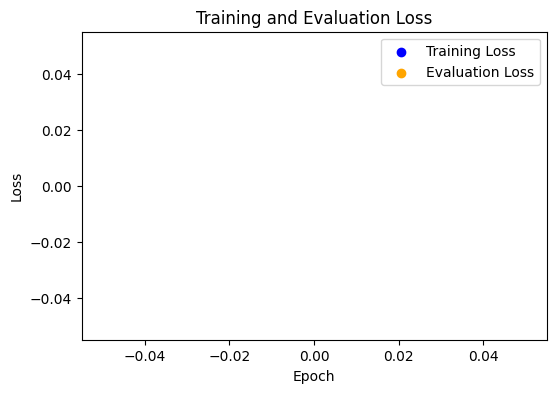

In [ ]:
train_losses = []
eval_losses = []
# Plotting the loss values
plt.figure(figsize=(6, 4))
plt.scatter(range(1,num_epochs+1), train_losses, label="Training Loss", color='blue')
plt.scatter(range(1,num_epochs+1), eval_losses, label="Evaluation Loss", color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

### Inference

In [ ]:
# Initialize the tokenizer with the BERT model's vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.eval()

def predict_nsp(sentence1, sentence2, model, tokenizer):
    # Tokenize sentences with special tokens
    tokens = tokenizer.encode_plus(sentence1, sentence2, return_tensors="pt")
    tokens_tensor = tokens["input_ids"].to(device)
    segment_tensor = tokens["token_type_ids"].to(device)

    # Predict
    with torch.no_grad():
        # Assuming the model returns NSP predictions first
        nsp_prediction, _ = model(tokens_tensor, segment_tensor)
        # Select the first element (first sequence) of the logits tensor
        first_logits = nsp_prediction[0].unsqueeze(0)  # Adds an extra dimension, making it [1, 2]
        logits = torch.softmax(first_logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()

    # Interpret the prediction
    return "Second sentence follows the first" if prediction == 1 else "Second sentence does not follow the first"

# Example usage
sentence1 = "The cat sat on the mat."
sentence2 = "It was a sunny day"

print(predict_nsp(sentence1, sentence2, model, tokenizer))

def predict_mlm(sentence, model, tokenizer):
    # Tokenize the input sentence and convert to token IDs, including special tokens
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens_tensor = inputs.input_ids

    # Create dummy segment labels filled with zeros, assuming it's needed by your model
    segment_labels = torch.zeros_like(tokens_tensor)

    with torch.no_grad():
        # Forward pass through the model, now correctly handling the output tuple
        output_tuple = model(tokens_tensor, segment_labels)

        # Assuming the second element of the tuple contains the MLM logits
        predictions = output_tuple[1]  # Adjusted based on your model's output

        # Identify the position of the [MASK] token
        mask_token_index = (tokens_tensor == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

        # Get the predicted index for the [MASK] token from the MLM logits
        predicted_index = torch.argmax(predictions[0, mask_token_index.item(), :], dim=-1)
        predicted_token = tokenizer.convert_ids_to_tokens([predicted_index.item()])[0]

        # Replace [MASK] in the original sentence with the predicted token
        predicted_sentence = sentence.replace(tokenizer.mask_token, predicted_token, 1)

    return predicted_sentence


# Example usage
sentence = "The cat sat on the [MASK]."
print(predict_mlm(sentence, model, tokenizer))

Second sentence follows the first
The cat sat on the [UNK].


# 9) Transformer

In [ ]:
from torchtext.datasets import multi30k, Multi30k